In [1]:
#read csv first
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df = pd.read_csv("insurance.csv")
print(df.shape)
df.head(5)
X,Y = df.iloc[:,:-1], df.iloc[:,-1]

(1338, 7)


zero variance issue:

In [2]:
#check out columns which have 0 variance
print(df.nunique())

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64


In [ ]:
#ok, seems like ok, there is no problem of 0 variance columns

Outlier issue:

In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


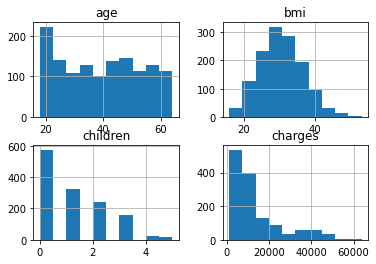

In [4]:
df.hist()
plt.show()

In [5]:
q25, q75 = np.percentile(df['age'], 25), np.percentile(df['age'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
outliers = [x for x in df['age'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
print(df.shape)

Identified outliers: 0
(1338, 7)


In [6]:
q25, q75 = np.percentile(df['bmi'], 25), np.percentile(df['bmi'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
outliers = [x for x in df['bmi'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
print(df.shape)
outliers_removed = [x for x in df['bmi'] if x >= lower and x <= upper] 
print('Non-outlier observations: %d' % len(outliers_removed))
df = df[(df['bmi'] >= lower) & (df['bmi'] <= upper)]	
print(df.shape)

Identified outliers: 9
(1338, 7)
Non-outlier observations: 1329
(1329, 7)


In [7]:
q25, q75 = np.percentile(df['children'], 25), np.percentile(df['children'], 75)
iqr = q75 - q25
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
outliers = [x for x in df['children'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
print(df.shape)

Identified outliers: 0
(1329, 7)


In [ ]:
#for 'charges' column, I decided to not to handle the outliers

In [ ]:
#ok, we solved outlier problems

missing value issue:

In [8]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [ ]:
#there are no missing values

In [9]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Machine Learning Pipeline

In [10]:
#Let me split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1,random_state=42)

<IPython.core.display.Javascript object>

In [11]:
#I'm building a ML pipeline which handles everything
#the preprocessing includes onehotencoder, robustscaler, power transformer,discretization.
#I like to use LightGBM model because it's very fast and has incredible performance
#The hyperparameter tunning will happen in my nested cross validation
import lightgbm as lgb
from sklearn.model_selection import RepeatedKFold,GridSearchCV,cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,PowerTransformer,KBinsDiscretizer,OrdinalEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest,f_regression

cv_inner = KFold(n_splits=10, shuffle=True, random_state=1)
cv_outer = KFold(n_splits=10,shuffle=True, random_state=1)

t = [('cat', OneHotEncoder(drop='first'), ['sex','smoker','region']),
     ('robust',RobustScaler(),['age','bmi','children']),
    ('power', PowerTransformer(method='yeo-johnson', standardize=True), ['bmi']),
    ('kbins',KBinsDiscretizer(encode='ordinal', strategy='kmeans'), ['bmi'])] 
col_transform = ColumnTransformer(transformers=t)
fs = SelectKBest(score_func=f_regression)
pipeline = Pipeline([('col', col_transform),
                     ('sel',fs),
                     ('m',lgb.LGBMRegressor(n_jobs=-1))])

grid = {
        'sel__k':[4,5,6],
        'm__n_estimators': [50,100,200],
        'm__num_leaves':[10,20],
        'm__max_bin': [110]}

scores = cross_validate(RandomizedSearchCV(pipeline, grid, scoring='r2', cv=cv_inner, n_jobs=-1,verbose = 0), 
                         X_train, y_train, cv=cv_outer, scoring='r2',n_jobs=-1,return_train_score=True,return_estimator=False,
                       verbose = 0)
print('train r2: %.3f (%.3f)' % (np.mean(scores['train_score']), np.std(scores['train_score'])))
print('test r2: %.3f (%.3f)' % (np.mean(scores['test_score']), np.std(scores['test_score'])))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

train r2: 0.885 (0.009)
test r2: 0.847 (0.049)


In [12]:
#save the pipeline using joblib
#also check out the performance on unseen dataset(X_test)
from sklearn import metrics
pipeline.fit(X_train,y_train)
yhat = pipeline.predict(X_test)
print('R Squared:', metrics.r2_score(y_test, yhat))

import joblib
joblib.dump(pipeline,'pipe_model')

R Squared: 0.8373640674781733


['pipe_model']

In [13]:
model = joblib.load('pipe_model')
pd.DataFrame(model.predict(X_test)).rename(columns={0:'yhat'}).head(5)

,yhat
0,11450.926474
1,6286.921578
2,28092.173067
3,8410.246479
4,33324.853382
